# Regime Detection via Hidden Markov Models

## Abstract

We apply Gaussian Hidden Markov Models (HMMs) to identify distinct return regimes in a market-capitalization weighted cryptocurrency portfolio. The portfolio consists of the top 10 cryptocurrencies by market cap, rebalanced weekly, with daily returns analyzed from 2018 to 2025.

## Methodology

### Portfolio Construction

We construct a dynamic market-cap weighted portfolio:
- **Universe**: All cryptocurrencies with available market cap and price data
- **Selection**: Top 10 assets by market capitalization on each rebalancing date
- **Rebalancing Frequency**: Weekly
- **Weighting**: Market-cap weighted within selected assets

### Regime Detection Model

We fit Gaussian HMMs with $K \in \{2,3,4,5\}$ hidden states to the portfolio's daily returns. The model assumes:

$$r_t | s_t = k \sim \mathcal{N}(\mu_k, \sigma_k^2)$$

where $r_t$ is the portfolio return at time $t$, $s_t$ is the hidden regime state, and $(\mu_k, \sigma_k^2)$ are the mean and variance parameters for regime $k$. Regime transitions follow a first-order Markov process with transition matrix $\mathbf{A}$.

Model selection is performed using the Bayesian Information Criterion (BIC):

$$\text{BIC} = -2 \log L + p \log n$$

where $L$ is the likelihood, $p$ is the number of parameters, and $n$ is the sample size.

### Data

- **Period**: 2020-01-01 to 2025-11-24
- **Frequency**: Daily returns
- **Source**: Historical market cap and price data


In [32]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
import scipy.stats as stats
import warnings

from pathlib import Path

from utils import (
    load_aligned_data,
    construct_market_portfolio,
    compare_strategy_metrics
)

pd.options.display.float_format = "{:.6f}".format

warnings.filterwarnings("ignore")

In [33]:
DATA_DIR = Path("./data")
MARKET_CAP_FILE = DATA_DIR / "market_cap.csv"
PRICE_FILE = DATA_DIR / "daily_price.csv"
FEAR_GREED_FILE = DATA_DIR / "fear_greed_index.csv"

aligned_market_caps, aligned_prices, asset_returns = load_aligned_data(
    MARKET_CAP_FILE,
    PRICE_FILE,
    start_date=pd.Timestamp("2020-01-01"),
)

greed_fear_index = pd.read_csv(FEAR_GREED_FILE, index_col=0, parse_dates=True).squeeze()

print(f"Aligned market caps shape: {aligned_market_caps.shape}")
print(f"Aligned prices shape: {aligned_prices.shape}")
print(f"Aligned returns shape: {asset_returns.dropna().shape}")


Aligned market caps shape: (2164, 20)
Aligned prices shape: (2164, 20)
Aligned returns shape: (75, 20)


## Portfolio Construction

The market-cap weighted portfolio is constructed by selecting the top 10 assets by market capitalization on each weekly rebalancing date.


In [34]:
# Portfolio configuration: Weekly rebalancing, daily returns
REBALANCING_FREQ = 'W'
TOP_ASSETS = 10

daily_market_portfolio = construct_market_portfolio(
    aligned_market_caps,
    asset_returns,
    rebalancing_freq=REBALANCING_FREQ,
    top_n=TOP_ASSETS,
).dropna()

print(f"Portfolio: {len(daily_market_portfolio)} daily returns")
print(f"Date range: {daily_market_portfolio.index.min()} to {daily_market_portfolio.index.max()}")


Portfolio: 2160 daily returns
Date range: 2020-01-05 00:00:00 to 2025-12-04 00:00:00


We can take a look at the distribution of the returns. Note that the returns of the market returns do not look normal and seem to exhibit extremely fat tails compared to a normal distribution. However, we still fit Gaussian HMM and see later that the assumptions of a Gaussian HMM still hold for crypto returns, as a Gaussian HMM only required the returns to be normally distributed inside of their own corresponding regime.

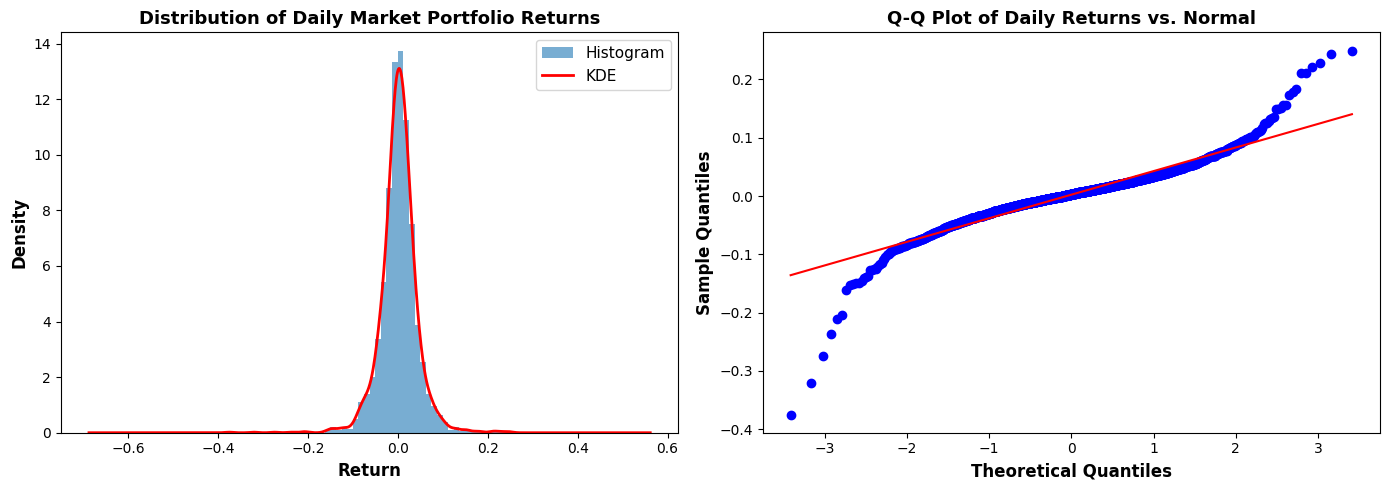

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

returns = daily_market_portfolio

axs[0].hist(returns, bins=50, density=True, alpha=0.6, label='Histogram')
returns.plot(kind='kde', ax=axs[0], color='red', label='KDE', linewidth=2)
axs[0].set_title('Distribution of Daily Market Portfolio Returns', fontsize=13, fontweight='bold')
axs[0].set_xlabel('Return', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Density', fontsize=12, fontweight='bold')
axs[0].legend(fontsize=11)

stats.probplot(returns, dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot of Daily Returns vs. Normal', fontsize=13, fontweight='bold')
axs[1].set_xlabel('Theoretical Quantiles', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Sample Quantiles', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Overall Market Sentiment via Fear Greed Index

he Crypto Fear & Greed Index is calculated by aggregating six key market indicators, each weighted equally:

- Volatility (25%): Measures current volatility and maximum drawdowns of Bitcoin compared to its 30-day and 90-day averages. Unusual volatility indicates fear.
- Market Momentum/Volume (25%): Compares current Bitcoin trading volume and market momentum to 30-day and 90-day averages. High buying volumes in positive markets suggest greed.
- Social Media (15%): Analyzes sentiment and engagement on platforms like Twitter/X, tracking hashtags, mentions, and interaction rates related to Bitcoin and crypto.
- Surveys (15%): Conducts weekly polls asking crypto investors about their market sentiment (though this component is sometimes paused).
- Bitcoin Dominance (10%): Tracks Bitcoin's market share relative to altcoins. Rising dominance suggests fear (flight to safety), while declining dominance indicates greed (risk-on behavior).
- Google Trends (10%): Analyzes search query data for Bitcoin-related terms, with increased searches for terms like "Bitcoin price manipulation" indicating fear, while searches for "Bitcoin" during rallies suggest greed.

These six components are normalized to a 0-100 scale and averaged to produce the final index score, where 0-24 indicates Extreme Fear, 25-49 is Fear, 50-74 is Greed, and 75-100 is Extreme Greed.

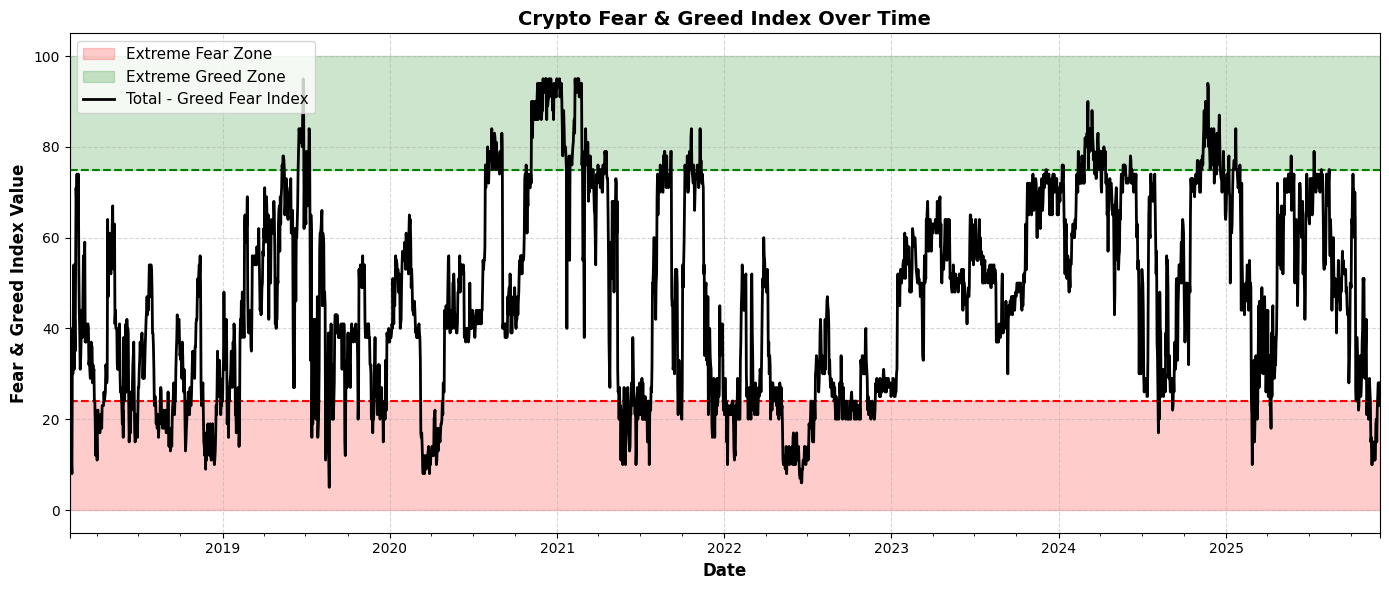

In [36]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.axhspan(0, 24, alpha=0.2, color='red', zorder=0, label='Extreme Fear Zone')

ax.axhspan(75, 100, alpha=0.2, color='green', zorder=0, label='Extreme Greed Zone')

greed_fear_index.plot(ax=ax, color='black', linewidth=2, zorder=3)

ax.axhline(24, color='red', linestyle='--', linewidth=1.5, zorder=2)
ax.axhline(75, color='green', linestyle='--', linewidth=1.5, zorder=2)

ax.set_title('Crypto Fear & Greed Index Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Fear & Greed Index Value', fontsize=12, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=11, loc='upper left')
plt.tight_layout()
plt.show()


Contrarians seem to believe that extreme fear is a good opportunity to buy, whereas extreme greed is a good opportunity to sell. However, we disprove this and show that this is in fact a very bad signal.

In [37]:
START_DATE = pd.Timestamp("2020-01-01")
THRESHOLD_LOW = 24
THRESHOLD_HIGH = 75

daily = daily_market_portfolio.loc[daily_market_portfolio.index >= START_DATE].sort_index()
gfi = greed_fear_index.loc[greed_fear_index.index >= START_DATE].sort_index()

common_idx = daily.index.intersection(gfi.index)
daily = daily.reindex(common_idx).dropna()
gfi = gfi.reindex(common_idx).dropna()

signal_A = pd.Series(index=gfi.index)
signal_A[gfi <= THRESHOLD_LOW] = 1
signal_A[gfi >= THRESHOLD_HIGH] = -1

signal_B = -signal_A

signal_A = signal_A.shift(1).reindex(daily.index).ffill()
signal_B = signal_B.shift(1).reindex(daily.index).ffill()

strategy_A_returns = signal_A * daily
strategy_B_returns = signal_B * daily

strategy_A_returns = strategy_A_returns.dropna()
strategy_B_returns = strategy_B_returns.dropna()

compare_strategy_metrics({
    "Market Portfolio": daily_market_portfolio,
    "Buy Fear Sell Greed": strategy_A_returns,
    "Buy Greed Sell Fear": strategy_B_returns
})

,Sharpe,Annual Mean Return,Annual Volatility,Max Drawdown
Strategy,,,,
Market Portfolio,1.032422,0.835865,0.809616,-0.786404
Buy Fear Sell Greed,-0.929091,-0.753379,0.810878,-0.998577
Buy Greed Sell Fear,0.929091,0.753379,0.810878,-0.661625


## HMM Model Fitting

We fit Gaussian HMMs with 2-5 states and select the optimal model using BIC. The HMM identifies distinct return regimes (e.g., bull, bear, neutral) with different mean returns and volatilities.


## Results: Full Period Analysis

### Regime Characteristics

The selected HMM identifies distinct regimes with different return distributions. 

In [40]:
# Fit HMM on daily returns
def fit_hmm_regimes(return_series: pd.Series, n_states: int = 2, random_state: int = 42):
    """Fit a Gaussian HMM and label regimes by ascending mean return."""
    clean_returns = return_series.dropna()
    data = clean_returns.values.reshape(-1, 1)
    
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type='full',
        n_iter=500,
        random_state=random_state,
    )
    model.fit(data)
    
    raw_states = model.predict(data)
    ordered_states = np.argsort(model.means_.flatten())
    state_mapping = {state: rank for rank, state in enumerate(ordered_states)}
    normalized_states = np.vectorize(state_mapping.get)(raw_states)
    
    if n_states == 2:
        regime_labels = {0: 'Bearish', 1: 'Bullish'}
    elif n_states == 3:
        # Map: State 0 (lowest mean) -> Extreme, State 1 (middle) -> Bear, State 2 (highest) -> Bull
        regime_labels = {0: 'Extreme', 1: 'Bear', 2: 'Bull'}
    else:
        regime_labels = {state: f"Regime {state + 1}" for state in range(n_states)}
    
    regime_df = pd.DataFrame({
        'Return': clean_returns,
        'State': normalized_states,
        'Regime': [regime_labels[s] for s in normalized_states],
    })
    
    log_likelihood = model.score(data)
    n_features = data.shape[1]
    n_params = (
        n_states * (n_states - 1) +
        (n_states - 1) +
        n_states * n_features +
        n_states * n_features * n_features
    )
    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(len(clean_returns))
    
    regime_stats = regime_df.groupby('Regime')['Return'].agg(['count', 'mean', 'std', 'min', 'max'])
    
    return {
        'model': model,
        'regime_df': regime_df,
        'regime_stats': regime_stats,
        'log_likelihood': log_likelihood,
        'aic': aic,
        'bic': bic,
    }

# Find best number of states
STATE_RANGE = range(2, 6)
state_results = []
for n_states in STATE_RANGE:
    summary = fit_hmm_regimes(daily_market_portfolio, n_states=n_states, random_state=7)
    summary['states'] = n_states
    state_results.append(summary)
    print(f"States={n_states}: LogL={summary['log_likelihood']:.2f}, AIC={summary['aic']:.2f}, BIC={summary['bic']:.2f}")

best_summary = min(state_results, key=lambda s: s['bic'])
regime_df = best_summary['regime_df'].sort_index()
print(f"\nSelected: {best_summary['states']} states (BIC={best_summary['bic']:.2f})")

# Define colors for regimes
# Bear - light red
# Bull - light green
# Extreme - light gray
regime_colors = {
    'Extreme': 'lightgray',
    'Bear': 'lightcoral',      # Bear (was Regime 2)
    'Bull': 'lightgreen',      # Bull (was Regime 3)
    'Regime 1': 'lightgray',   # Legacy support
    'Regime 2': 'lightcoral',  # Legacy support
    'Regime 3': 'lightgreen',  # Legacy support
    'Bearish': 'lightcoral',   # For 2-state models
    'Bullish': 'lightgreen'    # For 2-state models
}
unique_regimes = regime_df['Regime'].unique()
# Fill in any missing regimes with default colors
for reg in unique_regimes:
    if reg not in regime_colors:
        regime_colors[reg] = 'lightgray'

States=2: LogL=4074.95, AIC=-8135.90, BIC=-8096.15
States=3: LogL=4125.87, AIC=-8223.74, BIC=-8144.25
States=4: LogL=4132.56, AIC=-8219.12, BIC=-8088.53
States=5: LogL=4151.66, AIC=-8235.32, BIC=-8042.27

Selected: 3 states (BIC=-8144.25)


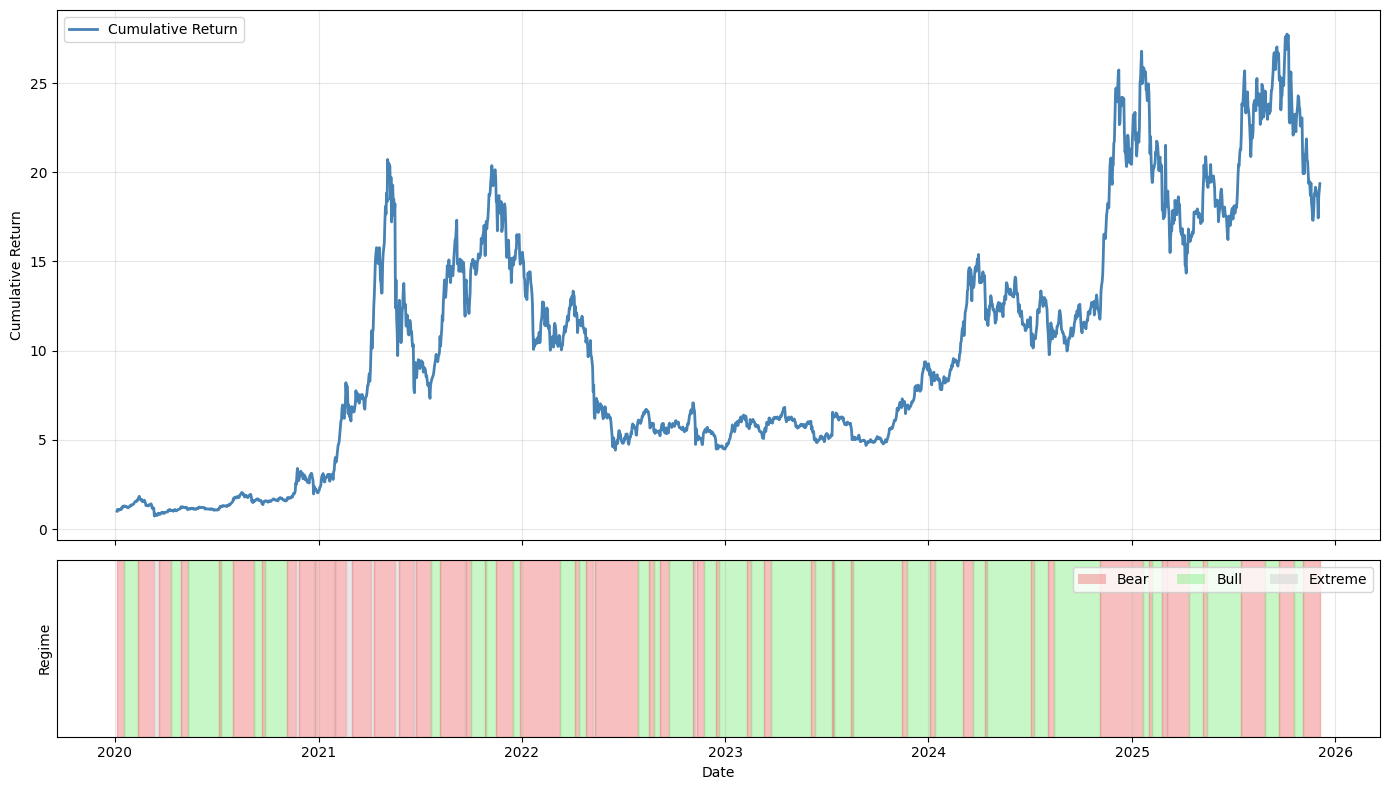

In [41]:
# 1.1 Cumulative returns with regime colors below
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, height_ratios=[3, 1])

# Top: Cumulative returns
cumulative = (1 + regime_df['Return']).cumprod()
ax1.plot(cumulative.index, cumulative.values, color='steelblue', linewidth=2, label='Cumulative Return')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Regime colors
dates = regime_df.index
regimes = regime_df['Regime'].values
prev_regime = None
start_idx = 0
for i, reg in enumerate(regimes):
    if reg != prev_regime:
        if prev_regime is not None:
            ax2.axvspan(dates[start_idx], dates[i], alpha=0.5, color=regime_colors[prev_regime])
        start_idx = i
        prev_regime = reg
if start_idx < len(dates):
    ax2.axvspan(dates[start_idx], dates[-1], alpha=0.5, color=regime_colors[prev_regime])

handles = [plt.Rectangle((0,0),1,1, facecolor=regime_colors[reg], alpha=0.5) for reg in unique_regimes]
ax2.legend(handles, unique_regimes, loc='upper right', ncol=min(len(unique_regimes), 4))
ax2.set_ylabel('Regime')
ax2.set_xlabel('Date')
ax2.set_yticks([])
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## Results: 2025 Analysis

Analysis of regime behavior in 2025, including cumulative returns and regime transitions.


REGIME STATISTICS
        Mean (Annualized) Volatility (Annualized) Total Return  Count
Regime                                                               
Bear               54.42%                  87.91%       51.79%    975
Bull              104.75%                  40.92%     1859.63%   1128
Extreme           163.61%                 290.68%      -34.90%     57


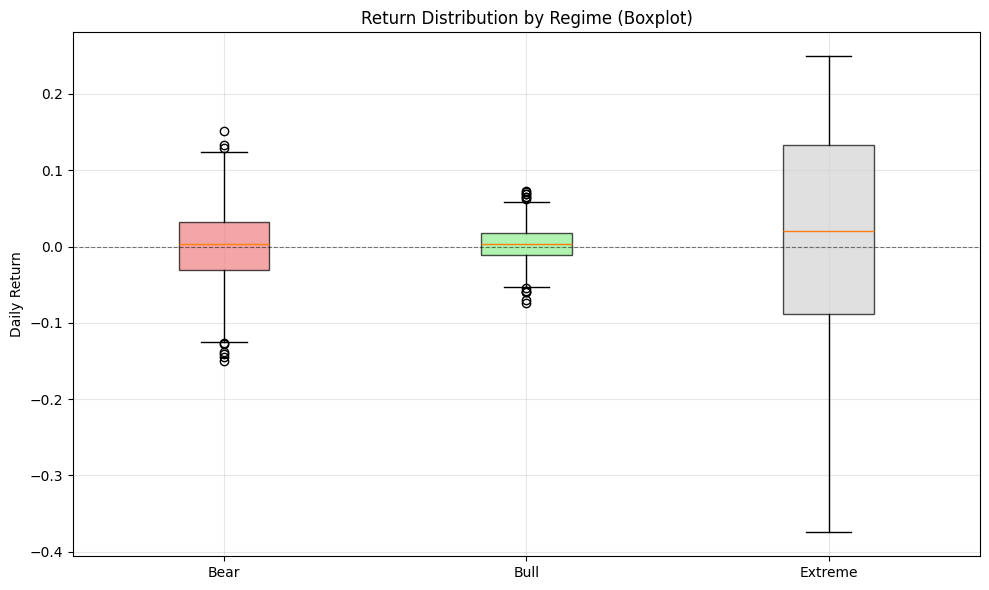

In [52]:
# 1.2 Regime Statistics Table (Mean, Volatility, Total Return)
regime_stats = best_summary['regime_stats']
regime_total_returns = regime_df.groupby('Regime')['Return'].apply(lambda r: (1 + r).prod() - 1)

# Annualize mean and volatility
annual_factor = 365
annualized_mean = regime_stats['mean'] * annual_factor
annualized_vol = regime_stats['std'] * np.sqrt(annual_factor)

# Create comprehensive statistics table
stats_table = pd.DataFrame({
    'Mean (Annualized)': annualized_mean,
    'Volatility (Annualized)': annualized_vol,
    'Total Return': regime_total_returns,
    'Count': regime_stats['count'],
})

# Format as percentages with 2 decimal places
stats_table_formatted = stats_table.copy()
stats_table_formatted['Mean (Annualized)'] = stats_table_formatted['Mean (Annualized)'].apply(lambda x: f"{x:.2%}")
stats_table_formatted['Volatility (Annualized)'] = stats_table_formatted['Volatility (Annualized)'].apply(lambda x: f"{x:.2%}")
stats_table_formatted['Total Return'] = stats_table_formatted['Total Return'].apply(lambda x: f"{x:.2%}")

print("="*70)
print("REGIME STATISTICS")
print("="*70)
print(stats_table_formatted)
print("="*70)

# 1.3 Boxplot
fig, ax = plt.subplots(figsize=(10, 6))
box_data = [regime_df.loc[regime_df['Regime'] == reg, 'Return'].values for reg in unique_regimes]
bp = ax.boxplot(box_data, tick_labels=unique_regimes, patch_artist=True)
for patch, reg in zip(bp['boxes'], unique_regimes):
    patch.set_facecolor(regime_colors[reg])
    patch.set_alpha(0.7)
ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_title('Return Distribution by Regime (Boxplot)')
ax.set_ylabel('Daily Return')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Here we can see in fact that the returns are normally distributed in the bear and bull regime, which suggests that the assumptions of the Gaussian HMM are valid and it fit the data well.

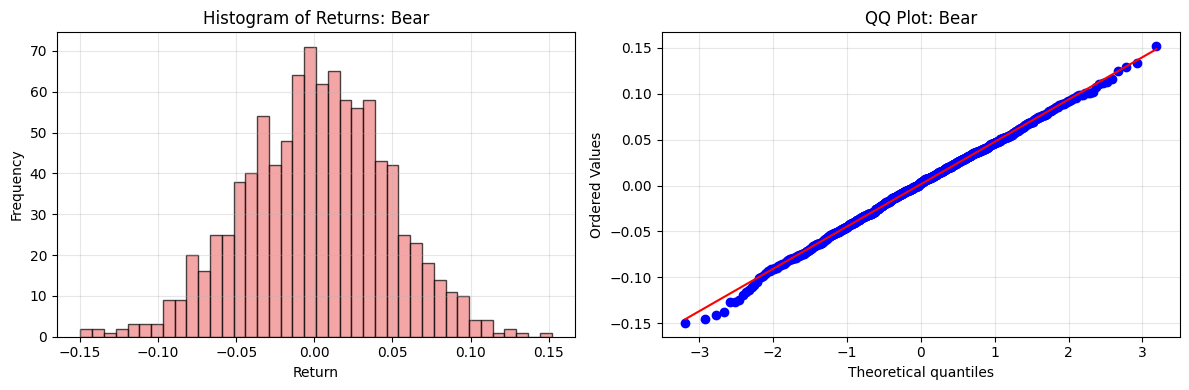

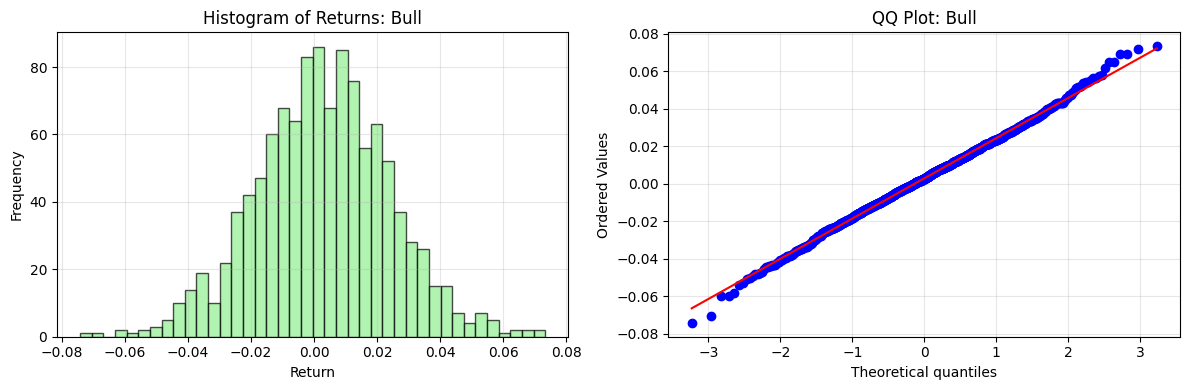

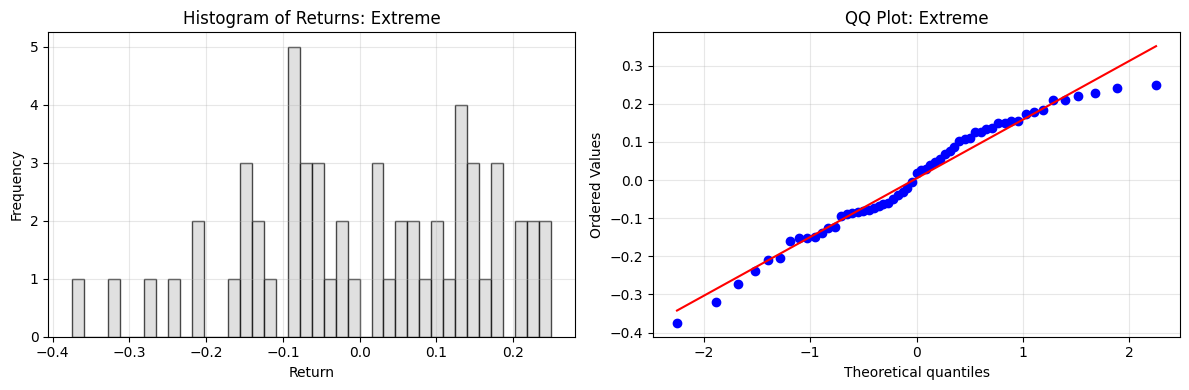

In [43]:
for reg in unique_regimes:
    returns = regime_df.loc[regime_df['Regime'] == reg, 'Return'].values
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    axs[0].hist(returns, bins=40, color=regime_colors[reg], alpha=0.7, edgecolor='black')
    axs[0].set_title(f'Histogram of Returns: {reg}')
    axs[0].set_xlabel('Return')
    axs[0].set_ylabel('Frequency')
    axs[0].grid(True, alpha=0.3)

    # QQ plot
    stats.probplot(returns, dist="norm", plot=axs[1])
    axs[1].set_title(f'QQ Plot: {reg}')
    axs[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

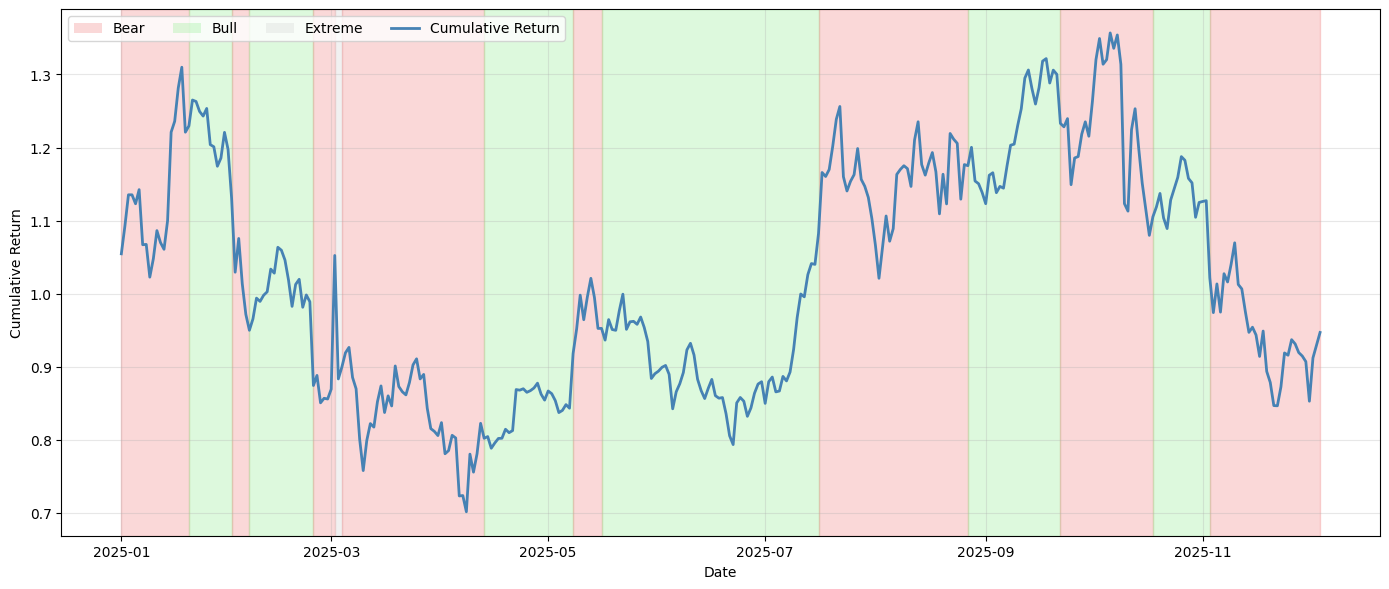

In [44]:
# 2.1 Cumulative returns with regime colors for 2025
regime_df_2025 = regime_df.loc[regime_df.index.year == 2025].copy().sort_index()

if len(regime_df_2025) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Cumulative returns line for 2025
    cumulative_2025 = (1 + regime_df_2025['Return']).cumprod()
    ax.plot(cumulative_2025.index, cumulative_2025.values, color='steelblue', linewidth=2, label='Cumulative Return', zorder=2)
    
    # Regime colors underneath
    dates_2025 = regime_df_2025.index
    regimes_2025 = regime_df_2025['Regime'].values
    prev_regime = None
    start_idx = 0
    for i, reg in enumerate(regimes_2025):
        if reg != prev_regime:
            if prev_regime is not None:
                ax.axvspan(dates_2025[start_idx], dates_2025[i], alpha=0.3, color=regime_colors[prev_regime], zorder=0)
            start_idx = i
            prev_regime = reg
    if start_idx < len(dates_2025):
        ax.axvspan(dates_2025[start_idx], dates_2025[-1], alpha=0.3, color=regime_colors[prev_regime], zorder=0)
    
    unique_regimes_2025 = regime_df_2025['Regime'].unique()
    handles = [plt.Rectangle((0,0),1,1, facecolor=regime_colors[reg], alpha=0.3) for reg in unique_regimes_2025]
    ax.legend(handles + [plt.Line2D([0], [0], color='steelblue', linewidth=2)], 
              list(unique_regimes_2025) + ['Cumulative Return'], 
              loc='upper left', ncol=min(len(unique_regimes_2025) + 1, 5))
    ax.set_ylabel('Cumulative Return')
    ax.set_xlabel('Date')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for 2025")


## Regime Duration Analysis

We analyze the duration distribution of Bear regime periods:
- **Unconditional distribution**: Distribution of all Bear regime lengths
- **Conditional distribution**: Distribution of remaining length given current duration $k$

This analysis helps understand regime persistence and potential duration forecasting.


SUMMARY OF ALL REGIMES
Bear: 48 periods, mean length: 20.31 days
Bull: 34 periods, mean length: 33.18 days
Extreme: 13 periods, mean length: 4.38 days

Bear regime identified as: Bear (mean return: 0.001491)

UNCONDITIONAL DISTRIBUTION OF BEAR REGIME LENGTHS

Unconditional Distribution:
Length          Count           Probability    
---------------------------------------------
1               2               0.0417         
2               1               0.0208         
3               2               0.0417         
4               2               0.0417         
5               2               0.0417         
6               4               0.0833         
7               1               0.0208         
8               3               0.0625         
9               1               0.0208         
10              2               0.0417         
11              1               0.0208         
13              4               0.0833         
14              1               0.0208    

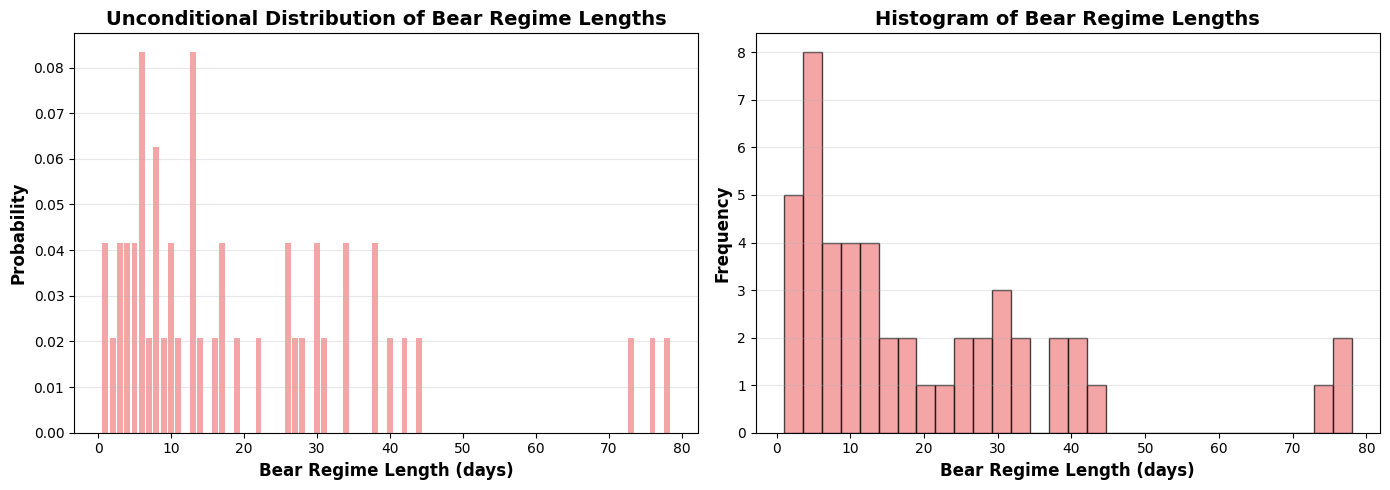


MEAN LENGTH OF BEAR REGIME
Mean Bear Regime Length: 20.31 days
Median: 13.00 days
Std Dev: 18.79 days
Min: 1 days, Max: 78 days
Total number of Bear regime periods: 48


In [50]:
# 2.2.1 Unconditional Distribution of Bear Regime Lengths
def calculate_regime_lengths(regime_series):
    """Calculate lengths of consecutive regime periods."""
    lengths = []
    current_regime = None
    current_length = 0
    
    for reg in regime_series:
        if reg == current_regime:
            current_length += 1
        else:
            if current_regime is not None:
                lengths.append((current_regime, current_length))
            current_regime = reg
            current_length = 1
    if current_regime is not None:
        lengths.append((current_regime, current_length))
    
    return lengths

# Show summary of all regimes
print("="*70)
print("SUMMARY OF ALL REGIMES")
print("="*70)
all_lengths = calculate_regime_lengths(regime_df['Regime'].values)
regime_summary = {}
for regime, length in all_lengths:
    if regime not in regime_summary:
        regime_summary[regime] = []
    regime_summary[regime].append(length)

for regime in sorted(regime_summary.keys()):
    lengths = regime_summary[regime]
    print(f"{regime}: {len(lengths)} periods, mean length: {np.mean(lengths):.2f} days")
print()

# Identify Bear regime (check if "Bear" exists, otherwise use lowest mean return)
regime_means = regime_df.groupby('Regime')['Return'].mean()
if 'Bear' in regime_means.index:
    bear_regime = 'Bear'
else:
    # Fallback: find bearish regime (lowest mean return)
    bear_regime = regime_means.idxmin()
print(f"Bear regime identified as: {bear_regime} (mean return: {regime_means[bear_regime]:.6f})\n")

# Calculate all bear regime lengths
bear_lengths = np.array([length for regime, length in all_lengths if regime == bear_regime])

if len(bear_lengths) > 0:
    # Unconditional distribution of bear regime lengths
    unique_lengths, counts = np.unique(bear_lengths, return_counts=True)
    unconditional_dist = pd.Series(counts, index=unique_lengths) / len(bear_lengths)
    
    print("="*70)
    print("UNCONDITIONAL DISTRIBUTION OF BEAR REGIME LENGTHS")
    print("="*70)
    print("\nUnconditional Distribution:")
    print(f"{'Length':<15} {'Count':<15} {'Probability':<15}")
    print("-"*45)
    for length, prob in sorted(unconditional_dist.items()):
        count = counts[unique_lengths == length][0]
        print(f"{length:<15} {count:<15} {prob:<15.4f}")
    
    # Visualize unconditional distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1.bar(unconditional_dist.index, unconditional_dist.values, alpha=0.7, color='lightcoral')
    ax1.set_xlabel('Bear Regime Length (days)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Probability', fontsize=12, fontweight='bold')
    ax1.set_title('Unconditional Distribution of Bear Regime Lengths', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    ax2.hist(bear_lengths, bins=min(30, len(unique_lengths)), alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.set_xlabel('Bear Regime Length (days)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Histogram of Bear Regime Lengths', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Mean of unconditional distribution
    print("\n" + "="*70)
    print("MEAN LENGTH OF BEAR REGIME")
    print("="*70)
    mean_length = np.mean(bear_lengths)
    print(f"Mean Bear Regime Length: {mean_length:.2f} days")
    print(f"Median: {np.median(bear_lengths):.2f} days")
    print(f"Std Dev: {np.std(bear_lengths):.2f} days")
    print(f"Min: {np.min(bear_lengths)} days, Max: {np.max(bear_lengths)} days")
    print(f"Total number of Bear regime periods: {len(bear_lengths)}")
else:
    print("No Bear regime periods found in the data")

In [51]:
# 2.2.2 Conditional Distribution of Bear Regime Length
# Ensure bear_regime and bear_lengths are defined (from previous cell)
if 'bear_regime' not in locals():
    regime_means = regime_df.groupby('Regime')['Return'].mean()
    if 'Bear' in regime_means.index:
        bear_regime = 'Bear'
    else:
        bear_regime = regime_means.idxmin()
    all_lengths = calculate_regime_lengths(regime_df['Regime'].values)
    bear_lengths = np.array([length for regime, length in all_lengths if regime == bear_regime])

# Infer current length k from the current Bear regime period (if we're in Bear regime)
if len(regime_df) > 0:
    # Find the current regime (last regime in the series)
    current_regime = regime_df['Regime'].iloc[-1]
    # If currently in Bear regime, calculate current length
    if current_regime == bear_regime:
        current_length = 1
        for i in range(len(regime_df) - 2, -1, -1):
            if regime_df['Regime'].iloc[i] == bear_regime:
                current_length += 1
            else:
                break
        k = current_length
        print(f"Currently in {bear_regime}, current length: {k} days")
    else:
        # If not in Bear regime, use the length of the most recent Bear regime period
        all_lengths_list = calculate_regime_lengths(regime_df['Regime'].values)
        bear_periods = [(regime, length) for regime, length in all_lengths_list if regime == bear_regime]
        if len(bear_periods) > 0:
            k = bear_periods[-1][1]  # Length of most recent Bear regime period
            print(f"Not currently in {bear_regime}. Using most recent {bear_regime} period length: {k} days")

if len(bear_lengths) > 0:
    print("="*70)
    print(f"CONDITIONAL DISTRIBUTION OF BEAR REGIME LENGTH")
    print(f"Given current_length >= {k}")
    print("="*70)
    print(f"P(Length = k | Length >= {k})")
    print("-"*70)
    
    max_length = int(np.max(bear_lengths))
    print(f"Maximum Bear regime length observed: {max_length} days\n")
    
    # Filter to periods that are at least k days long
    periods_at_least = bear_lengths[bear_lengths >= k]
    
    if len(periods_at_least) > 0:
        # Conditional distribution: P(length = k | length >= k)
        conditional_probs = {}
        for length_k in range(k, max_length + 1):
            count_k = np.sum(periods_at_least == length_k)
            if count_k > 0:
                conditional_probs[length_k] = count_k / len(periods_at_least)
        
        if len(conditional_probs) > 0:
            print(f"\nConditional Distribution given current_length >= {k}:")
            print(f"{'Length (k)':<15} {'P(k | >= {})'.format(k):<15}")
            print("-"*30)
            for length_k in sorted(conditional_probs.keys()):
                print(f"{length_k:<15} {conditional_probs[length_k]:<15.4f}")
            
            expected_length = sum(length_k * p for length_k, p in conditional_probs.items())
            print(f"\nExpected total length: {expected_length:.2f} days")
            print(f"Number of periods with length >= {k}: {len(periods_at_least)}")
        else:
            print(f"No periods found with length >= {k}")
    else:
        print(f"No periods found with length >= {k}")
else:
    print("No Regime 1 periods found - cannot calculate conditional distribution")


Currently in Bear, current length: 31 days
CONDITIONAL DISTRIBUTION OF BEAR REGIME LENGTH
Given current_length >= 31
P(Length = k | Length >= 31)
----------------------------------------------------------------------
Maximum Bear regime length observed: 78 days


Conditional Distribution given current_length >= 31:
Length (k)      P(k | >= 31)   
------------------------------
31              0.0909         
34              0.1818         
38              0.1818         
40              0.0909         
42              0.0909         
44              0.0909         
73              0.0909         
76              0.0909         
78              0.0909         

Expected total length: 48.00 days
Number of periods with length >= 31: 11
